# <font color=teal>imports</font>

In [1]:
import os
import sys
sys.path.append(os.path.abspath("../src"))

In [2]:
from  src import *


# <font color=teal>housekeeping</font>

In [3]:
db = database_loader.DatabaseLoader(get_config('connection_string'))
DEBUG=False
COMMIT_TO_DATABASE=True
SCHEMA='controls'

# <font color=teal>game info data</font>
Aggregated up from the play-by-play dataset.

We want each team to have its own record for each season and week.

So for any given game there will be two records, one for the home team having its stats, and another for the away team - having the opposite stats

In [4]:
# We want each team to have a record for each season and week.

game_df = db.query_to_df("""
   --home team labels
    select season,
           week,
           home_team                 as team,
           home_score                as team_score,
           home_coach                as team_coach,
           away_team                 as opposing_team,
           away_score                as opposing_score,
           away_coach                as opposing_coach,
           (home_score - away_score) as spread,
           count(*)

    from controls.game_info G
    group by season, week, home_team, home_score, away_score, away_team, home_coach, away_coach
    UNION ALL
    --away team labels
    select season,
           week,
           away_team                 as team,
           away_score                as team_score,
           away_coach                as team_coach,
           home_team                 as opposing_team,
           home_score                as opposing_score,
           home_coach                as opposing_coach,
           (away_score - home_score) as spread,
           count(*)

    from controls.game_info G
    group by season, week, home_team, home_score, away_score, away_team, home_coach, away_coach
""")

game_df.head()

,season,week,team,team_score,team_coach,opposing_team,opposing_score,opposing_coach,spread,count
0,2022,4,LV,32,Josh McDaniels,DEN,23,Nathaniel Hackett,9,1
1,2017,16,WAS,27,Jay Gruden,DEN,11,Vance Joseph,16,1
2,2017,6,HOU,33,Bill O'Brien,CLE,17,Hue Jackson,16,1
3,2019,5,TEN,7,Mike Vrabel,BUF,14,Sean McDermott,-7,1
4,2021,4,GB,27,Matt LaFleur,PIT,17,Mike Tomlin,10,1


### <font color="#9370DB">A single game should have two 'opposite' records</font>
let's check that out for the 2017 match between DEN and NYG

In [5]:
game_df.loc[(game_df.season==2017) & (game_df.week==6) & (game_df.team.isin(['DEN', 'NYG']))]

,season,week,team,team_score,team_coach,opposing_team,opposing_score,opposing_coach,spread,count
923,2017,6,DEN,10,Vance Joseph,NYG,23,Ben McAdoo,-13,1
2829,2017,6,NYG,23,Ben McAdoo,DEN,10,Vance Joseph,13,1


### <font color="#9370DB">There should be no team with two records for any give week</font>
let's validate that

In [6]:
# fail if there are any group counts > 1
double_counts = game_df.loc[(game_df['count'].astype(int) > 1)].shape[0]
assert double_counts == 0

# <font color=teal>next gen stats passing<font/>
group by <font color=red>season, week, team</font> ( and top-passing-player_position )

In [7]:
%%time
ngs_air_power = db.query_to_df("""
    with base as (
    select season, week, team_abbr as team,
           pass_touchdowns,
           avg_time_to_throw,
           avg_completed_air_yards,
           avg_intended_air_yards,
           avg_air_yards_differential,
           aggressiveness,
           max_completed_air_distance,
           avg_air_yards_to_sticks,
           attempts,
           pass_yards,
           interceptions,
           passer_rating,
           completions,
           completion_percentage,
           expected_completion_percentage,
           completion_percentage_above_expectation,
           avg_air_distance,
           max_air_distance,
        row_number() over (partition by season, week, team_abbr, player_position order by pass_yards desc) as rn
    from controls.nextgen_pass
--    where season=2016 and week=1 and team_abbr = 'CHI'
    order by team_abbr, player_position, season desc, week )
    select * from base where rn = 1 and week > 0
""")

ngs_air_power.head()


CPU times: user 17.8 ms, sys: 2.42 ms, total: 20.3 ms
Wall time: 40.2 ms


,season,week,team,pass_touchdowns,avg_time_to_throw,avg_completed_air_yards,avg_intended_air_yards,avg_air_yards_differential,aggressiveness,max_completed_air_distance,...,pass_yards,interceptions,passer_rating,completions,completion_percentage,expected_completion_percentage,completion_percentage_above_expectation,avg_air_distance,max_air_distance,rn
0,2022,1,ARI,2,2.803059,3.766818,7.508125,-3.741307,14.705882,38.423006,...,193,0,99.264706,22,64.705882,63.872274,0.833608,20.780448,55.361811,1
1,2022,2,ARI,1,2.631918,3.560323,5.360213,-1.799890,16.326531,38.988774,...,277,1,76.658163,31,63.265306,67.953796,-4.688490,17.729007,39.697620,1
2,2022,3,ARI,0,2.432569,3.848108,5.682364,-1.834256,8.620690,37.932599,...,314,0,77.801724,37,63.793103,72.002558,-8.209454,18.993060,51.283168,1
3,2022,4,ARI,2,2.733469,4.967391,5.964839,-0.997447,3.125000,38.072149,...,207,1,96.744792,23,71.875000,67.395659,4.479341,20.337519,44.226310,1
4,2022,5,ARI,1,2.681950,3.378571,6.814474,-3.435902,11.904762,28.255430,...,250,1,80.456349,28,66.666667,63.948053,2.718614,20.096993,47.951656,1


## <font color=teal>next gen stats rushing<font/>
group by <font color=red>season, week, team</font>

In [8]:
%%time
ngs_ground_power = db.query_to_df("""
with base as (
    select season, week, team_abbr as team, rush_yards,
           efficiency,
           percent_attempts_gte_eight_defenders,
           avg_time_to_los,
           rush_attempts,
           expected_rush_yards,
           rush_yards_over_expected,
           avg_rush_yards,
           rush_yards_over_expected_per_att,
           rush_pct_over_expected,
           rush_touchdowns,
           player_gsis_id,
           player_first_name,
           player_last_name,
           player_jersey_number,
           player_short_name,
           row_number() over (partition by season, week, team_abbr order by rush_yards desc) as rn
    from controls.nextgen_rush
    order by  team_abbr, season desc, week)
select * from base where week > 0
""" )

ngs_ground_power.head()

CPU times: user 13.6 ms, sys: 1.71 ms, total: 15.3 ms
Wall time: 24.8 ms


,season,week,team,rush_yards,efficiency,percent_attempts_gte_eight_defenders,avg_time_to_los,rush_attempts,expected_rush_yards,rush_yards_over_expected,avg_rush_yards,rush_yards_over_expected_per_att,rush_pct_over_expected,rush_touchdowns,player_gsis_id,player_first_name,player_last_name,player_jersey_number,player_short_name,rn
0,2022,1,ARI,26,5.930769,10.000000,2.445889,10,35.285705,-9.285705,2.600000,-0.928570,0.400000,1,00-0033553,James,Conner,6,J.Conner,1
1,2022,3,ARI,39,5.421026,7.692308,2.580545,13,56.352659,-17.352659,3.000000,-1.334820,0.230769,0,00-0033553,James,Conner,6,J.Conner,1
2,2022,4,ARI,55,3.860545,40.000000,2.565267,15,44.522278,7.477722,3.666667,0.534123,0.642857,0,00-0033553,James,Conner,6,J.Conner,1
3,2022,6,ARI,37,5.610541,6.666667,2.708000,15,53.014218,-17.014218,2.466667,-1.215301,0.285714,0,00-0036383,Eno,Benjamin,26,E.Benjamin,1
4,2022,7,ARI,92,2.619457,8.333333,2.810818,12,44.221202,38.778798,7.666667,3.525345,0.545455,1,00-0036383,Eno,Benjamin,26,E.Benjamin,1


# <font color=teal>play-by-play events<font/>
players are called out for certain events like fumbles, touchdowns, etc. in play-by-play
we already picked these out during the transform step,
  and expanded so that each team has its own records irrespective of the opposing team played.
Now we pivot and sum all events by  <font color=red>season, week, team</font>

In [9]:
%%time
pbp_events = db.query_to_df("""
SELECT
    season, week, team,
    SUM(CASE WHEN event = 'fumble' THEN 1 else 0 END) AS fumble,
    SUM(CASE WHEN event = 'own_kickoff_recovery' THEN 1 else 0 END) AS own_kickoff_recovery,
    SUM(CASE WHEN event = 'safety' THEN 1 else 0 END) AS safety,
    SUM(CASE WHEN event = 'tackle' THEN 1 else 0 END) AS tackle,
    SUM(CASE WHEN event = 'qb_hit' THEN 1 else 0  END) AS qb_hit,
    SUM(CASE WHEN event = 'touchdown' THEN 1  else 0 END) AS touchdown,
    SUM(CASE WHEN event = 'interception' THEN 1 else 0 END) AS interception,
    SUM(CASE WHEN event = 'sack' THEN 1 else 0 END) AS sack
FROM controls.player_events where week > 0
group by season, week, team
order by season desc, team, week
""")

pbp_events.head()

CPU times: user 7.88 ms, sys: 1.21 ms, total: 9.09 ms
Wall time: 167 ms


,season,week,team,fumble,own_kickoff_recovery,safety,tackle,qb_hit,touchdown,interception,sack
0,2022,1,ARI,6,0,0,75,6,3,0,0
1,2022,2,ARI,2,0,0,61,5,4,0,1
2,2022,3,ARI,2,0,0,54,5,0,0,1
3,2022,4,ARI,3,0,0,57,3,3,2,2
4,2022,5,ARI,0,0,0,86,6,2,0,3


# <font color=teal>player stats<font/>
Each player's stats by are collected by game and play
For this dimension reduction exercise we roll up to <font color=red>season, week, team</font>

In [10]:
%%time
player_stats = db.query_to_df("""
select
    season,
    week,
    team,
    sum(completions) as ps_completions,
    sum(attempts) as ps_attempts,
    sum(passing_yards) as passing_yards,
    sum(passing_tds) as passing_tds,
    sum(interceptions) as ps_interceptions,
    sum(sacks) as sacks,
    sum(sack_yards) as sack_yards,
    sum(sack_fumbles) as sack_fumbles,
    sum(sack_fumbles_lost) as sack_fumbles_lost,
    sum(passing_air_yards) as passing_air_yards,
    sum(passing_yards_after_catch) as passing_yards_after_catch,
    sum(passing_first_downs) as passing_first_downs,
    avg(passing_epa) as passing_epa,
    sum(passing_2pt_conversions) as passing_2pt_conversions,
    avg(pacr) as avg_pacr,
    avg(dakota) as avg_dakota,
    sum(carries) as carries,
    sum(rushing_yards) as rushing_yards,
    sum(rushing_tds) as rushing_tds,
    sum(rushing_fumbles) as rushing_fumbles,
    sum(rushing_fumbles_lost) as rushing_fumbles_lost,
    sum(rushing_first_downs) as rushing_first_downs,
    avg(rushing_epa) as avg_rushing_epa,
    sum(rushing_2pt_conversions) as rushing_2pt_conversions,
    sum(receptions) as receptions,
    sum(targets) as targets,
    sum(receiving_yards) as receiving_yards,
    sum(receiving_tds) as receiving_tds,
    sum(receiving_fumbles) as receiving_fumbles,
    sum(receiving_fumbles_lost) as receiving_fumbles_lost,
    sum(receiving_air_yards) as receiving_air_yards,
    sum(receiving_yards_after_catch) as receiving_yards_after_catch,
    sum(receiving_first_downs) as receiving_first_downs,
    avg(receiving_epa) as avg_receiving_epa,
    sum(receiving_2pt_conversions) as receiving_2pt_conversions,
    sum(racr) as racr,
    sum(target_share) as target_share,
    sum(air_yards_share) as air_yards_share,
    sum(wopr) as wopr,
    sum(special_teams_tds) as special_teams_tds
from controls.player_stats
group by season,
week,
team
order by season desc, team,  week
""")

player_stats.head()

CPU times: user 153 ms, sys: 18 ms, total: 171 ms
Wall time: 468 ms


,season,week,team,ps_completions,ps_attempts,passing_yards,passing_tds,ps_interceptions,sacks,sack_yards,...,receiving_air_yards,receiving_yards_after_catch,receiving_first_downs,avg_receiving_epa,receiving_2pt_conversions,racr,target_share,air_yards_share,wopr,special_teams_tds
0,2022,1,ARI,24,38,205,2,0,3,26,...,266,115,12,0.680728,1,23.363950,1.0,1.0,2.2,0
1,2022,2,ARI,31,49,277,1,1,1,7,...,239,162,13,-0.302323,1,4.044793,1.0,1.0,2.2,0
2,2022,3,ARI,37,58,314,0,0,2,19,...,332,166,15,0.120710,0,-14.124653,1.0,1.0,2.2,0
3,2022,4,ARI,23,32,207,2,1,1,1,...,182,87,10,0.059163,0,1.130505,1.0,1.0,2.2,0
4,2022,5,ARI,28,42,250,1,1,1,11,...,293,144,16,1.347603,0,-14.683343,1.0,1.0,2.2,0


# <font color=teal>play by play analytics</font>
Analytics are part of the play-by-play dataset - they are collected for each play in each game.

For this dimensionality reduction step we roll them up to the player stats level.

The stats we get are for each play, and those probabilities
  and play level incrementals like WPA and EPA don't make sense in a rollup like this (I think)
  so for this rollup we'll use just EP and WP and well take the first and last metric form each season, week, team groping

We'll also separate home and away teams into their own set, so that for each game there will be two separate sets of analytics, one for the home team and one fr the away team.

### <font color="#9370DB">helper functions</font>

In [11]:
from typing import List, NamedTuple

class Col(NamedTuple):
    name: str
    alias: str

def build_pivot_sql(team_col: str,  pivot_cols: List[Col], additional_cols: List[Col]):
    db_table = 'controls.play_analytics'

    base_cols = ['season',
                 'week']
    metrics = []
    for col in pivot_cols:
        metrics.append(
            f"""
            MAX(CASE WHEN RN = 1 THEN {col.alias} END) AS start_{col.alias},
            MAX(CASE WHEN RN = (total_rows/2) THEN {col.alias} END) AS half_{col.alias}""")

    inner_cols = base_cols +  [f"{team_col} as team "] + [f"{p.name} as {p.alias}" for p in pivot_cols] + [f"{p.name} as {p.alias}" for p in additional_cols]
    inner_select = ",".join(inner_cols)

    outer_cols = base_cols + ["team"] +  [f"{p.alias}" for p in additional_cols] + metrics
    outer_select = ",".join(outer_cols)
    outer_group = ",".join(base_cols + ["team"] +  [f"{p.alias}" for p in additional_cols])

    station_cols = base_cols + [team_col]
    stations = ",".join(station_cols)

    sql = f"""
    WITH ranked_rows AS (
        SELECT {inner_select},
             ROW_NUMBER() OVER (PARTITION BY
                {stations} ORDER BY play_counter) AS RN,
             COUNT(*) OVER (PARTITION BY
                {stations}) AS total_rows
        FROM {db_table}
    )
    SELECT
        {outer_select}
    FROM ranked_rows
    GROUP BY {outer_group}
    order by season desc, team, week
    """

    if DEBUG:
        print(sql)
    return sql

def build_pivot(team_col: str,  pivot_cols: List[Col],  additional_cols: List[Col]):
    sql = build_pivot_sql(team_col, pivot_cols, additional_cols)
    df = db.query_to_df( sql )
    return df


### <font color="#9370DB">home team statistics</font>

In [12]:
%%time
pivot_cols = [
    Col('home_wp', "team_wp"),
    Col('away_wp', "opponent_wp"),
]

home_analytics_df = build_pivot(team_col="home_team", pivot_cols=pivot_cols, additional_cols=[Col("away_team", "opponent")])
home_analytics_df.head()

CPU times: user 3.96 ms, sys: 1.47 ms, total: 5.43 ms
Wall time: 886 ms


,season,week,team,opponent,start_team_wp,half_team_wp,start_opponent_wp,half_opponent_wp
0,2022,1,ARI,KC,0.566792,0.108674,0.433208,0.891326
1,2022,3,ARI,LA,0.546262,0.237108,0.453738,0.762892
2,2022,5,ARI,PHI,0.546262,0.350160,0.453738,0.649840
3,2022,7,ARI,NO,0.566792,0.835941,0.433208,0.164059
4,2022,9,ARI,SEA,0.566792,0.436939,0.433208,0.563061


### <font color="#9370DB">away team statistics</font>

In [13]:
%%time
pivot_cols = [
    Col('away_wp', "team_wp"),
    Col('home_wp', "opponent_wp")
]

away_analytics_df = build_pivot(team_col="away_team", pivot_cols=pivot_cols, additional_cols=[Col("home_team", "opponent")])
away_analytics_df.head()


CPU times: user 3.79 ms, sys: 1.52 ms, total: 5.31 ms
Wall time: 830 ms


,season,week,team,opponent,start_team_wp,half_team_wp,start_opponent_wp,half_opponent_wp
0,2022,2,ARI,LV,0.453738,0.034517,0.546262,0.965483
1,2022,4,ARI,CAR,0.433208,0.213143,0.566792,0.786857
2,2022,6,ARI,SEA,0.433208,0.298779,0.566792,0.701221
3,2022,8,ARI,MIN,0.453738,0.305759,0.546262,0.694241
4,2022,10,ARI,LA,0.453738,0.895184,0.546262,0.104816


### <font color="#9370DB">home and away team statistics appended together</font>

In [14]:
team_analytics = pd.concat([home_analytics_df, away_analytics_df])
team_analytics.head()

,season,week,team,opponent,start_team_wp,half_team_wp,start_opponent_wp,half_opponent_wp
0,2022,1,ARI,KC,0.566792,0.108674,0.433208,0.891326
1,2022,3,ARI,LA,0.546262,0.237108,0.453738,0.762892
2,2022,5,ARI,PHI,0.546262,0.350160,0.453738,0.649840
3,2022,7,ARI,NO,0.566792,0.835941,0.433208,0.164059
4,2022,9,ARI,SEA,0.566792,0.436939,0.433208,0.563061


# <font color=teal>validate that all of these datasets will merge 'horizontally'</font>
We want one record for each season, week and team.

The metrics themselves pivot horizontally as columns - all the metrics we created above become columns in this final dataset
so we expect that with each merge the number of columns grows, but the row count stays the same

Since we are using this dataset for dimensionality reduction it's ok if we loose a few rows on the join.


### <font color="#9370DB">helper functions</font>

In [15]:
from pandas import DataFrame

def calc_coverage(title: str, df: DataFrame):
    first = df.season.min()
    last = df.season.max()
    first_wk = df.week.min()
    last_wk = df.week.max()
    seasons = df.season.nunique()
    print(f"Shape of {title:30}:  {df.shape},\t Contains {seasons} seasons, starting with {first} and ending in {last} min week: {first_wk}, max week : {last_wk}")

def print_columns(title, df):
    print(f"\n---------\n{title.strip()} colums")
    for col in df.columns:
        print(col)

### <font color="#9370DB">get shapes before merge</font>

In [16]:
calc_coverage("Team analytics ", team_analytics)
calc_coverage("ngs_air_power  ", ngs_air_power)
calc_coverage("ngs_ground_power ", ngs_ground_power)
calc_coverage("pbp_events  ", pbp_events)
calc_coverage("player_stats  ", player_stats)
calc_coverage("game info  ", game_df)

Shape of Team analytics                :  (3812, 8),	 Contains 7 seasons, starting with 2016 and ending in 2022 min week: 1, max week : 22
Shape of ngs_air_power                 :  (3778, 22),	 Contains 7 seasons, starting with 2016 and ending in 2022 min week: 1, max week : 23
Shape of ngs_ground_power              :  (3825, 20),	 Contains 7 seasons, starting with 2016 and ending in 2022 min week: 1, max week : 23
Shape of pbp_events                    :  (3834, 11),	 Contains 7 seasons, starting with 2016 and ending in 2022 min week: 1, max week : 22
Shape of player_stats                  :  (12836, 43),	 Contains 24 seasons, starting with 1999 and ending in 2022 min week: 1, max week : 22
Shape of game info                     :  (3812, 10),	 Contains 7 seasons, starting with 2016 and ending in 2022 min week: 1, max week : 22


In [17]:
ngs_air_power.drop(columns=['rn'], inplace=True)
ngs_ground_power.drop(columns=['rn'], inplace=True)

In [18]:
if DEBUG:
    print_columns("Team analytics ", team_analytics)
    print_columns("ngs_air_power  ", ngs_air_power)
    print_columns("ngs_ground_power ", ngs_ground_power)
    print_columns("pbp_events  ", pbp_events)
    print_columns("player_stats  ", player_stats)
    print_columns("game Info     ", game_df)

### <font color="#9370DB">get shapes after each  merge</font>

In [19]:
merged = pd.merge(ngs_ground_power, ngs_air_power, on=['season', 'week', 'team'])
print("shape after merging ngs_ground_power + ngs_air_power ", merged.shape)
merged = pd.merge(merged, pbp_events, on=['season', 'week', 'team'])
print("shape after merging merged + pbp_events              ", merged.shape)
merged = pd.merge(merged, player_stats, on=['season', 'week', 'team'])
print("shape after merging merged + player_stats            ", merged.shape)
merged = pd.merge(merged, team_analytics, on=['season', 'week', 'team'])
print("shape after merging merged + team_analytics          ", merged.shape)
merged = pd.merge(merged, game_df, on=['season', 'week', 'team'])
print("shape after merging merged + game_df                 ", merged.shape)

merged.shape

shape after merging ngs_ground_power + ngs_air_power  (3788, 37)
shape after merging merged + pbp_events               (3569, 45)
shape after merging merged + player_stats             (3569, 85)
shape after merging merged + team_analytics           (3569, 90)
shape after merging merged + game_df                  (3569, 97)


(3569, 97)

### <font color="#9370DB">verify that there are no team weeks with more than one record</font>

In [20]:
%%time
overlaps = 0
for col in merged.columns:
    if str(col).endswith("_y") or str(col).endswith("_x") or str(col) == "rn":
        print(col)
        overlaps += 1

assert overlaps == 0


CPU times: user 43 µs, sys: 0 ns, total: 43 µs
Wall time: 45.1 µs


# <font color=teal>review and impute our new dataset</font>

### <font color="#9370DB">review our dataset</font>

In [21]:
team_week_stats = merged
total_rows = team_week_stats.shape[0]
team_week_stats.shape

(3569, 97)

In [22]:
team_week_stats.describe().T

,count,mean,std,min,25%,50%,75%,max
season,3569.0,2019.076212,2.001350,2016.000000,2017.000000,2019.000000,2021.000000,2022.000000
week,3569.0,9.610815,5.346734,1.000000,5.000000,10.000000,14.000000,21.000000
rush_yards,3569.0,68.535444,34.614856,1.000000,44.000000,61.000000,87.000000,253.000000
efficiency,3569.0,4.412037,3.214025,0.743469,3.337586,3.978810,4.831020,145.580000
percent_attempts_gte_eight_defenders,3569.0,23.942587,18.287360,0.000000,9.090909,20.689655,35.714286,94.117647
avg_time_to_los,3569.0,2.790922,0.253328,1.934786,2.614700,2.778500,2.947467,3.877923
rush_attempts,3569.0,15.768282,4.837360,10.000000,12.000000,15.000000,19.000000,38.000000
expected_rush_yards,2615.0,62.658798,22.510114,-2.649523,47.082491,59.002656,75.365660,163.239206
rush_yards_over_expected,2615.0,4.342349,23.733123,-57.119431,-11.105817,-0.358790,13.818038,170.366911
avg_rush_yards,3569.0,4.312757,1.709856,0.076923,3.200000,4.058824,5.125000,14.600000


### <font color="#9370DB">impute missing values</font>

In [23]:
missing_values = team_week_stats.isnull().sum().sort_values(ascending=False)
percentage_missing = (missing_values / total_rows) * 100
percentage_missing = percentage_missing.reset_index()
percentage_missing.columns = ['column', 'percentage_missing']
percentage_missing.head()


,column,percentage_missing
0,expected_rush_yards,26.730177
1,rush_yards_over_expected,26.730177
2,rush_yards_over_expected_per_att,26.730177
3,rush_pct_over_expected,26.730177
4,max_completed_air_distance,0.028019


In [24]:
# remove analytics columns that are null -- we can't zero them because that changes the overall scoring - they are all expeceted values anyway so should not really be included
# team_week_stats.drop(columns=['expected_rush_yards',  ])
cols = percentage_missing.loc[(percentage_missing.percentage_missing > 0), 'column'].to_numpy()
team_week_stats.drop(columns=cols, inplace=True)
team_week_stats.isnull().sum().sort_values(ascending=False)

season                   0
week                     0
receiving_fumbles        0
receiving_tds            0
receiving_yards          0
                        ..
completion_percentage    0
completions              0
passer_rating            0
interceptions            0
count                    0
Length: 88, dtype: int64

### <font color="#9370DB">interactively review distributions and decide which columns to keep</font>

#### helper functions

In [25]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns


def hist_charts(numeric_columns):
    # Calculate the number of rows and columns for the grid
    num_cols = 4
    num_rows = (len(numeric_columns.columns) + num_cols - 1) // num_cols

    # Generate separate histograms using seaborn for each numeric column
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3*num_rows))
    for i, column in enumerate(numeric_columns.columns):
        row = i // num_cols
        col = i % num_cols
        sns.set(style="ticks")
        sns.histplot(data=numeric_columns[column], bins=30, kde=True, ax=axes[row, col])
        axes[row, col].set_title(f"Histogram of {column}")

    # Adjust spacing between subplots
    plt.tight_layout()

    # Show the plots
    plt.show()

#### charts

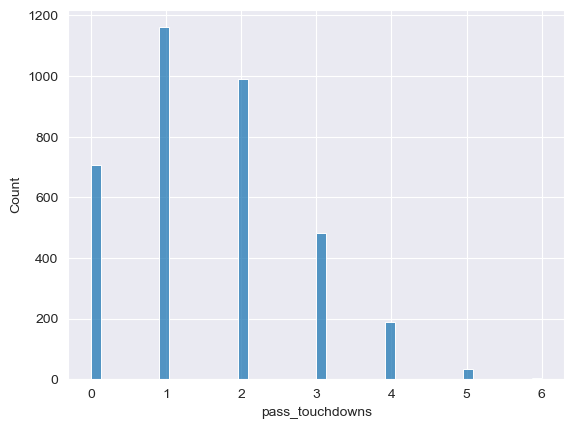

In [26]:
# review one at a time
sns.histplot(team_week_stats['pass_touchdowns'])
plt.show()

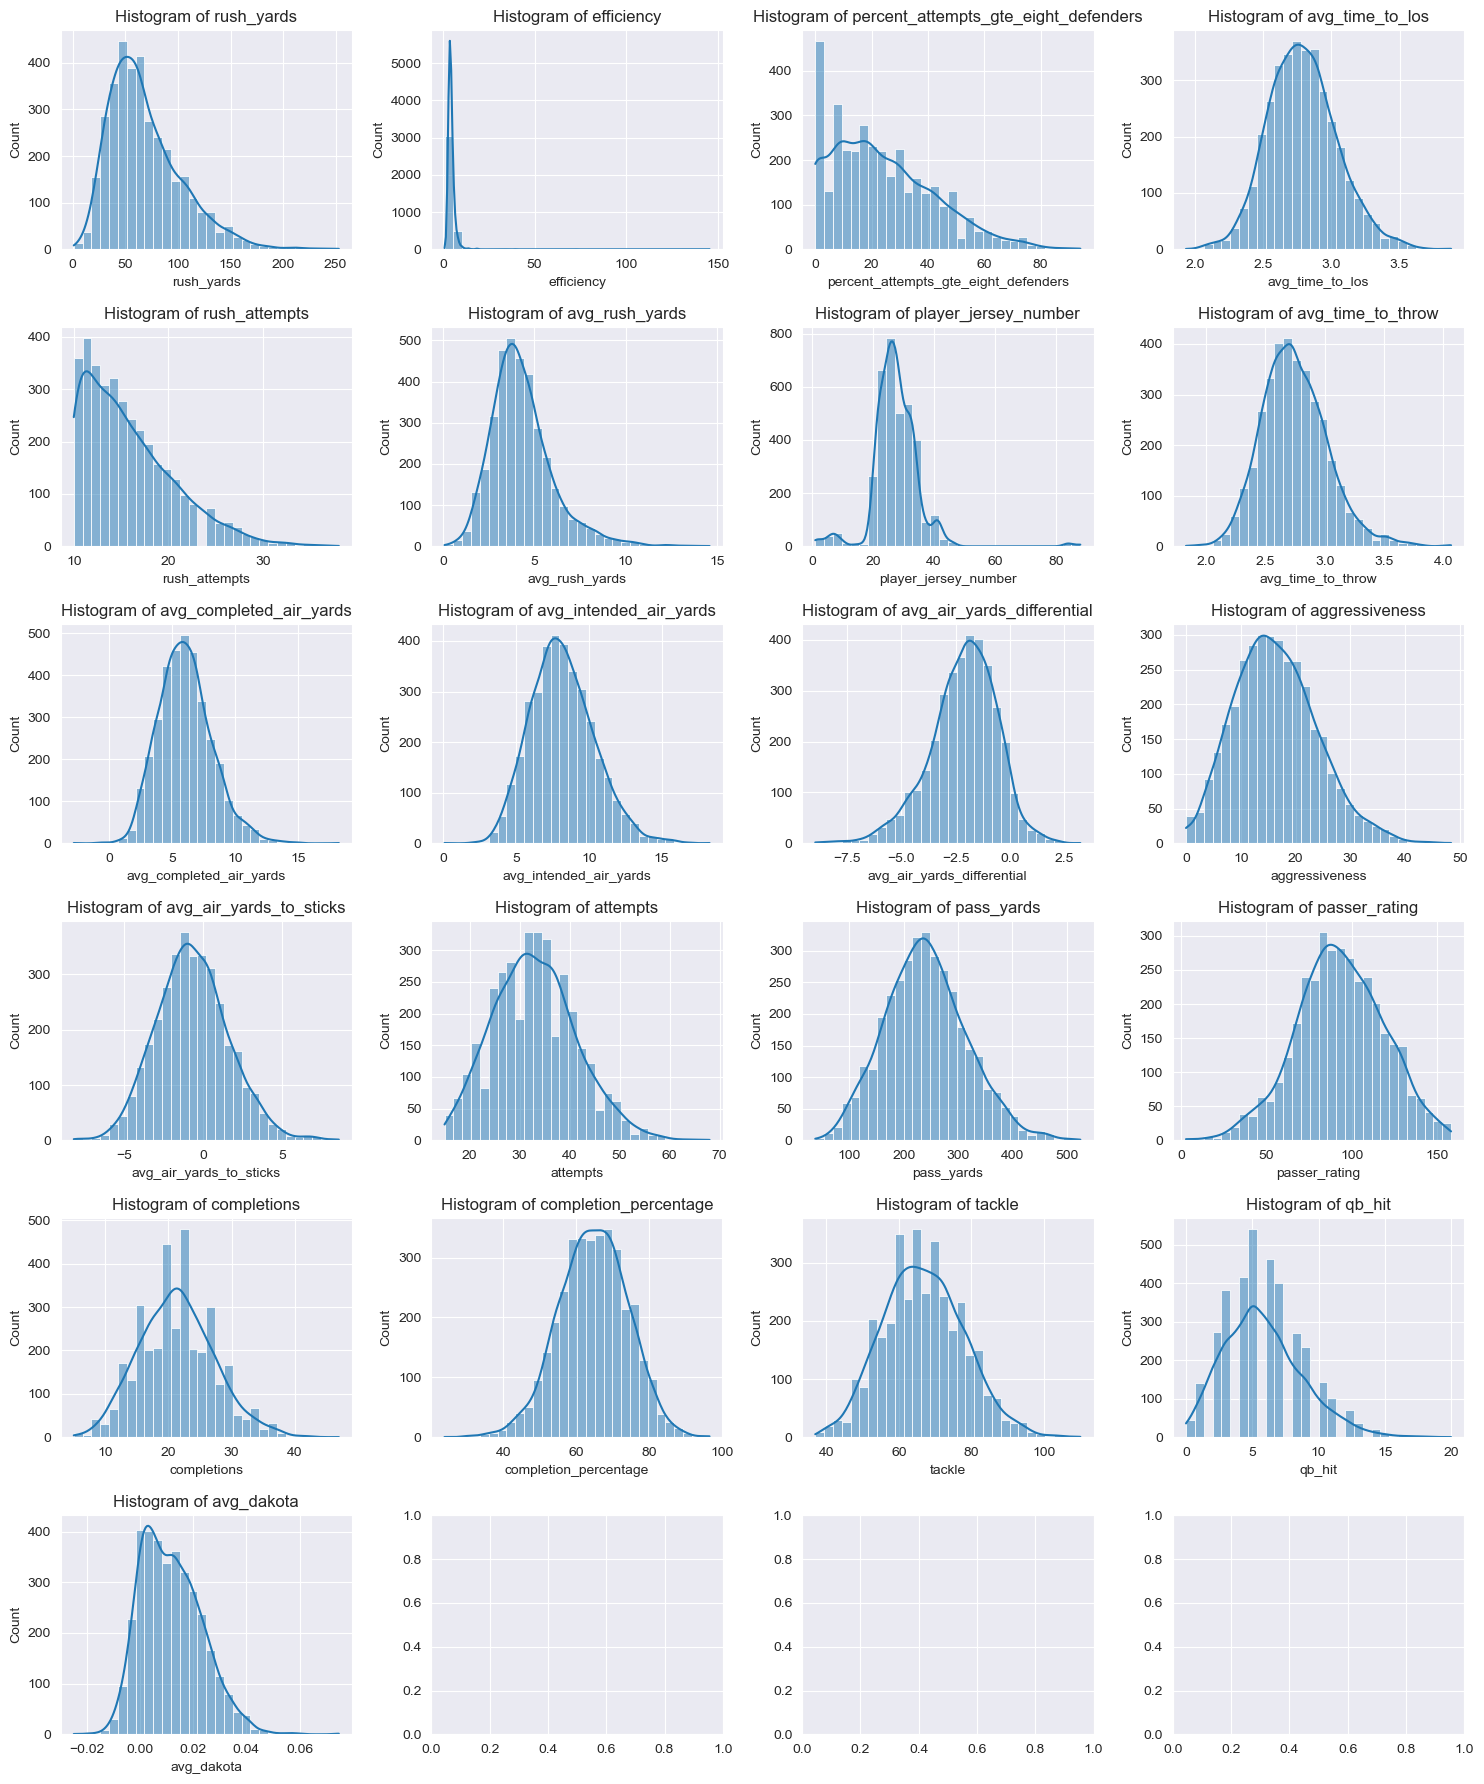

In [27]:
# review all numeric columns

# columns we've already decided to keep or drop
numeric_columns_to_drop={'start_team_wp', 'wopr', 'start_team_wp', 'half_team_wp', 'start_opponent_wp', 'half_opponent_wp',  'racr', 'avg_rushing_epa', 'avg_receiving_epa', 'target_share', 'passing_epa', 'avg_pacr', 'sack', 'count', 'interception', 'air_yards_share'}
numeric_columns_to_hide={'season','week', 'opposing_score', 'team_score', 'spread', 'interceptions'}

# all numeric columns and their values
numeric_columns = team_week_stats.select_dtypes(include='number').drop(columns=list(numeric_columns_to_drop.union(numeric_columns_to_hide)) ) ## review whats left over

# columns with less than '20' unique values are really categories - they don't really have a distribution worth looking at per-se
categorical_columns = set()
for column in numeric_columns.columns:
    n = len(numeric_columns[column].value_counts())
    if n < 20:
        categorical_columns.add(column)

# drop categorical columns from our numeric dataset
numeric_columns = numeric_columns.drop(columns=list(categorical_columns))

# review the distribution of the remaining columns
hist_charts(numeric_columns)

### <font color="#9370DB">drop the columns we don't need</font>

In [28]:
team_week_stats.drop(columns=list(numeric_columns_to_drop), inplace=True)

### <font color="#9370DB">make sure our potential labels for the upcoming dimension analysis is complete</font>

In [29]:
assert 0 == team_week_stats.spread.isna().sum()
assert 0 == team_week_stats.team_score.isna().sum()
assert 0 == team_week_stats.opposing_score.isna().sum()

### <font color="#9370DB">store to database</font>

In [30]:
%%time
if COMMIT_TO_DATABASE:
    db.load_table(merged, table_name="team_weekly_stats", schema=SCHEMA, handle_exists="replace")

CPU times: user 460 ms, sys: 19.9 ms, total: 480 ms
Wall time: 856 ms
